In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json
import glob
import os

plt.style.use('ggplot') # Make the graphs a bit prettier
pd.set_option('display.float_format', lambda x: '%.7f' % x)

In [2]:
data = {}

for path in glob.glob(os.path.expanduser("~/dev/ma/data/results/level0cluster/*.json")):
  for typename, items in json.load(open(path)).items():
    if typename in data:
      data[typename].update(items)
    else:
      data[typename] = items

frames = { typename: pd.DataFrame.from_dict(items, orient='index') for typename, items in data.items() }

In [13]:
frames['program_run']['order'] = frames['program_run']['graph'].map(lambda x: 'shuffled' if "uk-2002.metis-preprocessed" in x else 'original')

partitions = frames['partition']
partitions['algorithm'] = frames['partition'] \
    .merge(frames['program_run'], how='left', left_on='program_run_id', right_index=True) \
    .apply(lambda x: x.binary if x.algorithm == 'external' else x.algorithm, axis=1)
    
partitions.replace({ 'algorithm': { 'deterministic_greedy_with_linear_penalty': 'streaming', 'label_prop_partitioning': 'label propagation' } }, inplace=True)
    
graphs = frames['program_run'].loc[lambda x: x.binary == './louvain'] # .loc[lambda x: x.graph.str.contains("uk-2002.metis-preprocessed")]
algos = frames['algorithm_run'].merge(graphs, left_on='program_run_id', right_index=True)

In [14]:
frames['algorithm_level'] \
    .loc[lambda x: x.level == 0] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(graphs, left_on='program_run_id', right_index=True) \
    .loc[lambda x: x.algorithm.str.contains("sequential")] \
    ['cluster_count'] \
    .mean()

757191.0625

In [15]:
frames['algorithm_level'] \
    .loc[lambda x: x.level == 0] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(graphs, left_on='program_run_id', right_index=True) \
    .merge(partitions, left_on='partition_id', right_index=True) \
    .loc[lambda x: x.algorithm_x.str.contains("partitioned")] \
    .groupby(['order', 'algorithm_y', 'size', 'allow_move_to_ghosts'])['cluster_count'].mean()

order     algorithm_y        size  allow_move_to_ghosts
original  chunk              4     False                    902856.600000
                                   True                     959742.800000
                             16    False                    936219.200000
                                   True                    1015863.200000
                             64    False                    949801.600000
                                   True                    1036064.200000
                             256   False                    968145.200000
                                   True                    1051739.200000
                             1024  False                   1032546.000000
                                   True                    1102417.800000
          streaming          4     False                   2599321.800000
                                   True                    2269327.600000
                             16    False                

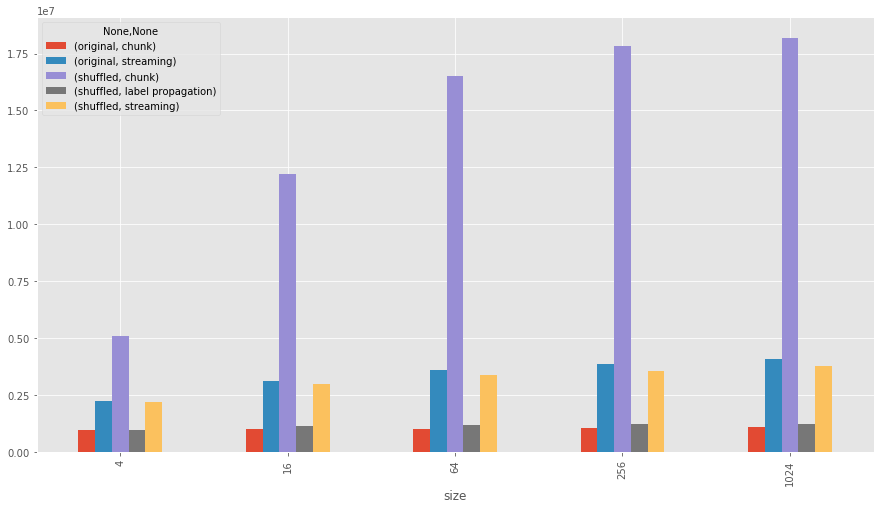

In [16]:
groups = frames['algorithm_level'] \
    .loc[lambda x: x.level == 0] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(graphs, left_on='program_run_id', right_index=True) \
    .merge(partitions, left_on='partition_id', right_index=True) \
    .loc[lambda x: x.algorithm_x.str.contains("partitioned")] \
    .loc[lambda x: x.allow_move_to_ghosts] \
    .groupby(['order', 'algorithm_y'], as_index=False)

#    .loc[lambda x: ~x.algorithm_y.isin(["deterministic_greedy_with_linear_penalty"])] \

pd.DataFrame({algo: levels.groupby('size')['cluster_count'].mean() for algo, levels in groups}).plot.bar(figsize=(15,8))

In [17]:
frames['clustering'] \
    .merge(algos, left_on='algorithm_run_id', right_index=True) \
    .loc[lambda x: x.algorithm.str.contains("sequential")] \
    ['modularity'].mean()

0.9897445

In [37]:
qual_data = frames['clustering'] \
    .merge(algos, left_on='algorithm_run_id', right_index=True) \
    .merge(partitions, left_on='partition_id', right_index=True) \
    .loc[lambda x: x.algorithm_x.str.contains("partitioned")] \
    .loc[lambda x: x.allow_move_to_ghosts] \
    .groupby(['order', 'algorithm_y', 'size'])['modularity'].mean()

qual_data.index = qual_data.index.rename(['order', 'partitioning algorithm', 'partition elements'])
    
print(qual_data.unstack(['partition elements']).to_latex())

\begin{tabular}{llrrrrr}
\toprule
         & partition elements &     4    &     16   &     64   &     256  &     1024 \\
order & partitioning algorithm &          &          &          &          &          \\
\midrule
original & chunk & 0.989281 & 0.989132 & 0.989080 & 0.989069 & 0.989076 \\
         & streaming & 0.989288 & 0.989179 & 0.989247 & 0.989213 & 0.989205 \\
shuffled & chunk & 0.989548 & 0.989467 & 0.989673 & 0.989710 & 0.989733 \\
         & label propagation & 0.989740 & 0.989739 & 0.989777 & 0.989773 & 0.989770 \\
         & streaming & 0.989644 & 0.989706 & 0.989725 & 0.989698 & 0.989591 \\
\bottomrule
\end{tabular}



In [38]:
qual_data = frames['clustering'] \
    .merge(algos, left_on='algorithm_run_id', right_index=True) \
    .merge(partitions, left_on='partition_id', right_index=True) \
    .loc[lambda x: x.algorithm_x.str.contains("partitioned")] \
    .loc[lambda x: x.allow_move_to_ghosts] \
    .groupby(['order', 'algorithm_y', 'size'])['cut_weight'].first()

qual_data.index = qual_data.index.rename(['order', 'partitioning algorithm', 'partition elements'])
    
print(qual_data.unstack(['partition elements']).to_latex())

\begin{tabular}{llrrrrr}
\toprule
         & partition elements &       4    &       16   &       64   &       256  &       1024 \\
order & partitioning algorithm &            &            &            &            &            \\
\midrule
original & chunk &    9404346 &   11754668 &   12642552 &   13792340 &   19288568 \\
         & streaming &   53014526 &   68323728 &   73633832 &   78585883 &   85501755 \\
shuffled & chunk &  198339260 &  246944129 &  258509423 &  261113135 &  261578869 \\
         & label propagation &   17376628 &   23864982 &   25929781 &   26655192 &   26960313 \\
         & streaming &   25095327 &   31906359 &   34145074 &   35090278 &   43401203 \\
\bottomrule
\end{tabular}

